### Packages

In [ ]:
!pip install einops visu3d tensorboardX diffusers transformers accelerate
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!git clone https://github.com/halixness/point-e

In [ ]:
%cd point-e/3d-diffusion

In [ ]:
!gdown https://drive.google.com/uc?id=1GarX4DA2FNPHeAUbzSkV1RuJC0Ci-SE5

### Stable Diffusion 2

In [18]:
from PIL import Image
import torch
import numpy as np
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.pyplot as plt
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# GLIDE 3B has been used // StableDiffusion 2 trained on LAION-5B
pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16,
).to(device)

# Low GPU ram mode (but slower) 
pipe.enable_attention_slicing()

# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

prompt = "roses in a pot"
prompt_details = ", solid white background, full body centered camera view, blender render, high resolution, standard light, no reflections"
generated_image = pipe(prompt + prompt_details).images[0]

Downloading:   0%|          | 0.00/539 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/633 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/460 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/939 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/611 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

  0%|          | 0/50 [00:00<?, ?it/s]

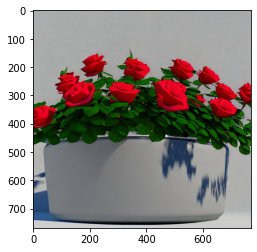

In [15]:
plt.imshow(generated_image)
PILtoTensor = transforms.ToTensor()

In [ ]:
del pipe
torch.cuda.empty_cache()

### 3DiM

In [16]:
from xunet import XUNet

import torch
import numpy as np
import torch.nn.functional as F

from tqdm import tqdm
from einops import rearrange
import time

from SRNdataset import dataset, MultiEpochsDataLoader
from tensorboardX import SummaryWriter
import os
import glob
from PIL import Image
import random

def logsnr_schedule_cosine(t, *, logsnr_min=-20., logsnr_max=20.):
    b = np.arctan(np.exp(-.5 * logsnr_max))
    a = np.arctan(np.exp(-.5 * logsnr_min)) - b
    
    return -2. * torch.log(torch.tan(a * t + b))

def xt2batch(x, logsnr, z, R, T, K):
    b = x.shape[0]
    

    return {
        'x': x.cuda(),
        'z': z.cuda(),
        'logsnr': torch.stack([logsnr_schedule_cosine(torch.zeros_like(logsnr)), logsnr], dim=1).cuda(),
        'R': R.cuda(),
        't': T.cuda(),
        'K':K[None].repeat(b,1,1).cuda(),
    }

# ----------------------- Diffusion forward process -----------------------

@torch.no_grad()
def sample(model, record, target_R, target_T, K, w, timesteps=256):
    """
        Forward process
    """
    b = w.shape[0]
    img = torch.randn_like(torch.tensor(record[0][0]))
    
    logsnrs = logsnr_schedule_cosine(torch.linspace(1., 0., timesteps+1)[:-1])
    logsnr_nexts = logsnr_schedule_cosine(torch.linspace(1., 0., timesteps+1)[1:])
    
    for logsnr, logsnr_next in tqdm(zip(logsnrs, logsnr_nexts), total=len(logsnrs), desc='diffusion loop', position=1, leave=False): # [1, ..., 0] = size is 257
        condition_img, condition_R, condition_T = random.choice(record)
        condition_img = torch.tensor(condition_img)
        condition_R = torch.tensor(condition_R)
        condition_T = torch.tensor(condition_T)
        
        R = torch.stack([condition_R, target_R], 0)[None].repeat(b, 1, 1, 1)
        T = torch.stack([condition_T, target_T], 0)[None].repeat(b, 1, 1)
        condition_img = condition_img
        img = p_sample(model,
                       z=img,
                       x=condition_img, 
                       R=R,
                       T=T,
                       K=K,
                       logsnr=logsnr, logsnr_next=logsnr_next,
                       w=w)
        
    return img.cpu().numpy()

def q_sample(z, logsnr, noise):
    """
        Forward: q(x_t|x_0)
    """
    # lambdas = logsnr_schedule_cosine(t)
    
    alpha = logsnr.sigmoid().sqrt()
    sigma = (-logsnr).sigmoid().sqrt()
    
    alpha = alpha[:,None, None, None]
    sigma = sigma[:,None, None, None]

    return alpha * z + sigma * noise


# ----------------------- Diffusion backward process -----------------------

@torch.no_grad()
def p_sample(model, x, z, R, T, K, logsnr, logsnr_next, w):
    """
        Backward process: epsilon_0(x_t, t)
    """
    
    model_mean, model_variance = p_mean_variance(model, x=x, z=z, R=R, T=T, K=K, logsnr=logsnr, logsnr_next=logsnr_next, w=w)
    
    if logsnr_next==0:
        return model_mean
    
    return model_mean + model_variance.sqrt() * torch.randn_like(x).cpu()


@torch.no_grad()
def p_mean_variance(model, x, z, R, T, K, logsnr, logsnr_next, w=2.0):
    """
        Backward process (and variance)
    """
    
    strt = time.time()
    b = x.shape[0]
    w = w[:, None, None, None]
    
    c = - torch.special.expm1(logsnr - logsnr_next)

    squared_alpha, squared_alpha_next = logsnr.sigmoid(), logsnr_next.sigmoid()
    squared_sigma, squared_sigma_next = (-logsnr).sigmoid(), (-logsnr_next).sigmoid()
    
    alpha, sigma, alpha_next = map(lambda x: x.sqrt(), (squared_alpha, squared_sigma, squared_alpha_next))
    
    # batch = xt2batch(x, logsnr.repeat(b), z, R)
    batch = xt2batch(x, logsnr.repeat(b), z, R, T, K)
    
    strt = time.time()

    # Predicted noise
    pred_noise = model(batch, cond_mask= torch.tensor([True]*b)).detach().cpu()
    batch['x'] = torch.randn_like(x).cuda()
    pred_noise_unconditioned = model(batch, cond_mask= torch.tensor([False]*b)).detach().cpu()
    
    pred_noise_final = (1+w) * pred_noise - w * pred_noise_unconditioned
    
    z = z.detach().cpu()
    
    # actual predicted x_0
    z_start = (z - sigma * pred_noise_final) / alpha
    z_start.clamp_(-1., 1.)
    
    model_mean = alpha_next * (z * (1 - c) / alpha + c * z_start)
    
    posterior_variance = squared_sigma_next * c
    
    return model_mean, posterior_variance


def p_losses(denoise_model, img, R, T, K, logsnr, noise=None, loss_type="l2", cond_prob=0.1):
    """
        Backward process loss: E[|| epsilon - epsilon_0(x_t, t)||]
    """
    B = img.shape[0]
    x = img[:, 0]
    z = img[:, 1]
    if noise is None:
        noise = torch.randn_like(x)

    z_noisy = q_sample(z=z, logsnr=logsnr, noise=noise)
    
    
    cond_mask = (torch.rand((B,)) > cond_prob).cuda()
    
    x_condition = torch.where(cond_mask[:, None, None, None], x, torch.randn_like(x))
    
    batch = xt2batch(x=x_condition, logsnr=logsnr, z=z_noisy, R=R, T=T, K=K)
    
    predicted_noise = denoise_model(batch, cond_mask=cond_mask.cuda())

    if loss_type == 'l1':
        loss = F.l1_loss(noise.to(device), predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise.to(device), predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise.to(device), predicted_noise)
    else:
        raise NotImplementedError()

    return loss

In [27]:
imgsize = 64

data_imgs = []

# Loading generated frame
img = generated_image.resize((imgsize, imgsize))
img = np.array(img) / 255 * 2 - 1

img = img.transpose(2,0,1)[:3].astype(np.float32)
data_imgs.append(img)

In [51]:
# Loading pose information
# R shape: (3,3)
# t shape: (1,3)
#pose_filename = os.path.join(args.target, 'pose', os.path.basename(img_filename)[:-4]+".txt")
#pose = np.array(open(pose_filename).read().strip().split()).astype(float).reshape((4,4))

# Pose format derived from shapenet
# Pose described as 3x3 matrix
# t param described as 1x3 vector

# print("--- Image")
# print("Pose R: ", pose[:3, :3])
# print("Pose T: ", pose[:3, 3])

data_Rs = []
data_Ts = []

# Assumption: frontal view: pose set as random (as long as: non singular matrices)
# TODO: find correct initialisation
data_Rs.append(torch.randn((3,3)))
data_Ts.append(torch.randn((3)))
data_K = torch.randn((3,3))

view loop:   0%|          | 0/1 [00:00<?, ?it/s]

diffusion loop:   0%|          | 0/256 [00:00<?, ?it/s]

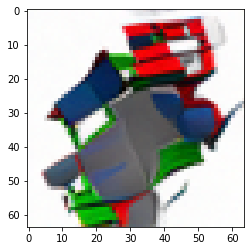

In [54]:
# Model
pretrained_model = "trained_model.pt"
model = XUNet(H=imgsize, W=imgsize, ch=128)
model = torch.nn.DataParallel(model)
model.to('cuda')

ckpt = torch.load(pretrained_model)
model.load_state_dict(ckpt['model'])

# Input image(s)
w = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7])
b = w.shape[0]
record = [[data_imgs[0][None].repeat(b, axis=0), 
           data_Rs[0],
           data_Ts[0]]]

# Straight sampling, given one example of images (data_imgs)
with torch.no_grad():
    step = 1
    start_idx = 0
    for gt, R, T in tqdm(zip(data_imgs[start_idx:], data_Rs[start_idx:], data_Ts[start_idx:]), total=len(data_imgs[start_idx:]), desc='view loop', position=0):
        
        R = torch.tensor(R)
        T = torch.tensor(T)

        img = sample(model, record=record, target_R=R, target_T=T, K=data_K, w=w)

        record.append([img, R.cpu().numpy(), T.cpu().numpy()])

        for i in w:
            generated_view = ((img[i].transpose(1,2,0)+1)*127.5).astype(np.uint8)
            plt.imshow(generated_view)
            #Image.fromarray().save(f'sampling/{step}/{i}.png')
        
        step += 1